<a href="https://colab.research.google.com/github/sanjaydinesh19/lstm-footwear-analysis/blob/main/LSTM_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Exploratory Data Analysis

In [102]:
# ============================
# 1.1 Runtime & library check
# ============================
import torch, sys
print("Python:", sys.version)
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
import random, os
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)




Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
PyTorch: 2.8.0+cu126
CUDA available: True


In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
# ============================
# 1.2 Upload the dataset
# ============================
DATA_PATH = "/content/drive/MyDrive/Research/Time Series Footwear/data.csv"

In [105]:
# ============================
# 1.3 Read CSV & inspect
# ============================
import pandas as pd
import numpy as np

df = pd.read_csv(DATA_PATH)

# Parse week_end_date as datetime
if 'week_end_date' in df.columns:
    df['week_end_date'] = pd.to_datetime(df['week_end_date'], errors='coerce')

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nDTypes:\n", df.dtypes)
print("\nDate range:", df['week_end_date'].min(), "→", df['week_end_date'].max())

display(df.head(10))

# Missing values report
na_counts = df.isna().sum().sort_values(ascending=False)
display(na_counts.to_frame("missing_count").T)


Shape: (8000, 13)

Columns: ['week_end_date', 'store_id', 'product_id', 'units_sold', 'units_returned', 'unit_price_inr', 'revenue_inr', 'promo_flag', 'discount_rate', 'avg_temp_c', 'rainfall_mm', 'neighborhood_trend_index', 'is_festival_season']

DTypes:
 week_end_date               datetime64[ns]
store_id                            object
product_id                          object
units_sold                           int64
units_returned                       int64
unit_price_inr                       int64
revenue_inr                          int64
promo_flag                           int64
discount_rate                      float64
avg_temp_c                         float64
rainfall_mm                        float64
neighborhood_trend_index           float64
is_festival_season                   int64
dtype: object

Date range: 2024-01-07 00:00:00 → 2025-07-13 00:00:00


,week_end_date,store_id,product_id,units_sold,units_returned,unit_price_inr,revenue_inr,promo_flag,discount_rate,avg_temp_c,rainfall_mm,neighborhood_trend_index,is_festival_season
0,2024-01-07,ST01,P001,24,2,2038,48912,0,0.15,28.8,31.5,95.3,1
1,2024-01-07,ST01,P002,20,2,1547,30940,0,0.00,26.7,12.0,98.8,1
2,2024-01-07,ST01,P003,15,4,2328,34920,0,0.00,24.4,34.2,102.9,1
3,2024-01-07,ST01,P004,21,0,3053,64113,0,0.00,24.3,13.3,115.2,1
4,2024-01-07,ST01,P005,12,2,961,11532,0,0.20,23.8,37.8,107.9,1
5,2024-01-07,ST01,P006,25,2,1563,39075,0,0.00,30.9,7.3,94.9,1
6,2024-01-07,ST01,P007,16,2,2498,39968,0,0.00,26.0,29.0,91.0,1
7,2024-01-07,ST01,P008,17,2,2695,45815,0,0.00,25.4,24.9,99.2,1
8,2024-01-07,ST01,P009,20,3,2681,53620,0,0.00,25.8,15.5,100.9,1
9,2024-01-07,ST01,P010,24,5,2522,60528,0,0.15,21.6,0.0,108.9,1


,week_end_date,store_id,product_id,units_sold,units_returned,unit_price_inr,revenue_inr,promo_flag,discount_rate,avg_temp_c,rainfall_mm,neighborhood_trend_index,is_festival_season
missing_count,0,0,0,0,0,0,0,0,0,0,0,0,0


In [106]:
# ============================
# 1.4 Basic stats & product coverage
# ============================
n_products = df['product_id'].nunique()
n_weeks = df['week_end_date'].nunique()
print(f"Products: {n_products} | Weeks: {n_weeks}")

# How many weeks per product
prod_counts = df.groupby('product_id')['week_end_date'].count().sort_values(ascending=False)
display(prod_counts.head(10).to_frame("rows_per_product").T)

# Descriptive stats for key metrics
display(df[["units_sold","unit_price_inr","discount_rate","revenue_inr"]].describe().T)

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

def wape(y_true, y_pred):
    return 100 * np.sum(np.abs(y_true - y_pred)) / (np.sum(np.abs(y_true)) + 1e-8)




Products: 20 | Weeks: 80


product_id,P001,P002,P003,P004,P005,P006,P007,P008,P009,P010
rows_per_product,400,400,400,400,400,400,400,400,400,400


,count,mean,std,min,25%,50%,75%,max
units_sold,8000.0,19.493375,4.797977,4.0,16.00,19.0,23.00,39.0
unit_price_inr,8000.0,2399.925250,922.606675,800.0,1623.75,2373.0,3193.25,3998.0
discount_rate,8000.0,0.044844,0.072185,0.0,0.00,0.0,0.10,0.2
revenue_inr,8000.0,46731.319375,21609.202955,5964.0,29478.75,44140.5,61248.00,153777.0


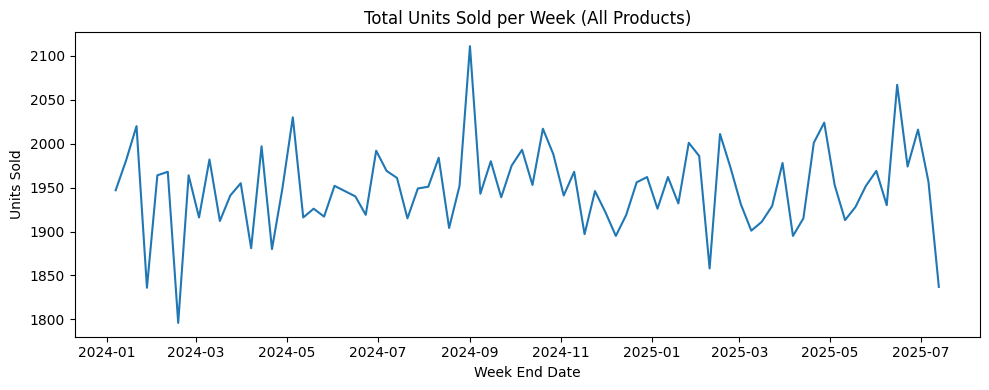

In [107]:
# ============================
# 1.5 Visualize aggregate demand
# ============================
import matplotlib.pyplot as plt

agg = (df.groupby('week_end_date', as_index=False)['units_sold']
         .sum()
         .sort_values('week_end_date'))

plt.figure(figsize=(10,4))
plt.plot(agg['week_end_date'], agg['units_sold'])
plt.title("Total Units Sold per Week (All Products)")
plt.xlabel("Week End Date")
plt.ylabel("Units Sold")
plt.tight_layout()
plt.show()


Top revenue product: P013


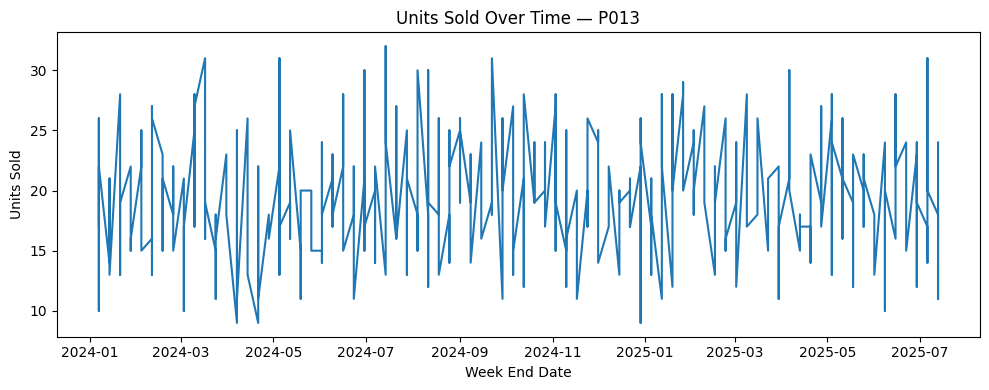

In [108]:
# ============================
# 1.6 Visualize top product demand
# ============================
top_prod = (df.groupby('product_id', as_index=False)['revenue_inr']
              .sum()
              .sort_values('revenue_inr', ascending=False)
              .iloc[0, 0])
print("Top revenue product:", top_prod)

one = df[df['product_id']==top_prod].copy().sort_values('week_end_date')

plt.figure(figsize=(10,4))
plt.plot(one['week_end_date'], one['units_sold'])
plt.title(f"Units Sold Over Time — {top_prod}")
plt.xlabel("Week End Date")
plt.ylabel("Units Sold")
plt.tight_layout()
plt.show()


In [109]:
# ============================
# 1.7 Feature correlation snapshot
# ============================
num_df = one[["units_sold", "units_returned", "unit_price_inr", "revenue_inr",
              "promo_flag", "discount_rate", "avg_temp_c", "rainfall_mm",
              "neighborhood_trend_index", "is_festival_season"]].copy()

corr = num_df.corr(numeric_only=True)
display(corr.style.background_gradient(cmap="coolwarm"))


,units_sold,units_returned,unit_price_inr,revenue_inr,promo_flag,discount_rate,avg_temp_c,rainfall_mm,neighborhood_trend_index,is_festival_season
units_sold,1.000000,0.391261,0.089746,0.573407,0.016118,-0.105680,-0.024806,-0.022625,-0.078482,-0.037631
units_returned,0.391261,1.000000,0.040323,0.226751,0.135510,0.038318,0.030760,-0.029610,0.014486,-0.048614
unit_price_inr,0.089746,0.040323,1.000000,0.845358,0.020121,0.065578,-0.027430,0.086336,0.049696,-0.009277
revenue_inr,0.573407,0.226751,0.845358,1.000000,0.036424,-0.005819,-0.031595,0.052305,0.004805,-0.015509
promo_flag,0.016118,0.135510,0.020121,0.036424,1.000000,-0.032997,-0.043810,0.022877,0.092838,-0.080427
discount_rate,-0.105680,0.038318,0.065578,-0.005819,-0.032997,1.000000,-0.005797,0.094049,-0.016664,0.034946
avg_temp_c,-0.024806,0.030760,-0.027430,-0.031595,-0.043810,-0.005797,1.000000,-0.002883,0.042561,-0.093508
rainfall_mm,-0.022625,-0.029610,0.086336,0.052305,0.022877,0.094049,-0.002883,1.000000,0.000497,0.065006
neighborhood_trend_index,-0.078482,0.014486,0.049696,0.004805,0.092838,-0.016664,0.042561,0.000497,1.000000,0.008134
is_festival_season,-0.037631,-0.048614,-0.009277,-0.015509,-0.080427,0.034946,-0.093508,0.065006,0.008134,1.000000


# 2. Aggregation and ABC Analysis

In [110]:
# ============================
# 2.1 Aggregate by Product Week
# ============================
# Ensure aggregation at product-week level (sums for counts, means for continuous signals)
agg_funcs = {
    "units_sold": "sum",
    "units_returned": "sum",
    "revenue_inr": "sum",
    "unit_price_inr": "mean",
    "promo_flag": "sum",  # total stores running promo
    "discount_rate": "mean",
    "avg_temp_c": "mean",
    "rainfall_mm": "mean",
    "neighborhood_trend_index": "mean",
    "is_festival_season": "max"  # 1 if any store flagged it
}

df_weekly = (df.groupby(["product_id", "week_end_date"], as_index=False)
               .agg(agg_funcs)
               .sort_values(["product_id","week_end_date"])
               .reset_index(drop=True))
print("Shape:", df_weekly.shape)
display(df_weekly.head(10))

Shape: (1600, 12)


,product_id,week_end_date,units_sold,units_returned,revenue_inr,unit_price_inr,promo_flag,discount_rate,avg_temp_c,rainfall_mm,neighborhood_trend_index,is_festival_season
0,P001,2024-01-07,103,11,182963,1816.0,2,0.05,27.02,14.76,95.30,1
1,P001,2024-01-14,111,8,235674,2111.0,2,0.03,26.52,19.46,108.62,1
2,P001,2024-01-21,93,11,263529,2746.6,0,0.00,27.16,22.94,97.08,1
3,P001,2024-01-28,95,6,311624,3284.0,0,0.04,25.74,20.18,101.90,1
4,P001,2024-02-04,77,8,182410,2357.0,0,0.07,26.74,15.70,102.82,0
5,P001,2024-02-11,117,6,282309,2457.2,0,0.02,28.56,14.04,97.46,0
6,P001,2024-02-18,86,10,195262,2262.8,1,0.03,30.14,16.90,104.52,0
7,P001,2024-02-25,74,8,201807,2621.4,3,0.10,29.74,21.34,97.48,0
8,P001,2024-03-03,110,5,282263,2511.8,0,0.04,28.96,22.30,97.14,0
9,P001,2024-03-10,89,9,168776,1901.2,1,0.00,29.58,22.24,104.06,0


In [111]:
# ============================
# 2.2 ABC Analysis
# ============================
# Compute total revenue per product
revenue_per_prod = (df_weekly.groupby("product_id", as_index=False)["revenue_inr"]
                              .sum()
                              .sort_values("revenue_inr", ascending=False))
# Cumulative revenue share
total_rev = revenue_per_prod["revenue_inr"].sum()
revenue_per_prod["cum_share"] = revenue_per_prod["revenue_inr"].cumsum() / total_rev * 100

# Assign ABC class
def abc_class(x):
    if x <= 80: return "A"   # top 80%
    elif x <= 95: return "B" # next 15%
    else: return "C"         # last 5%
revenue_per_prod["ABC"] = revenue_per_prod["cum_share"].apply(abc_class)

display(revenue_per_prod)

,product_id,revenue_inr,cum_share,ABC
12,P013,19321524,5.168248,A
0,P001,19290742,10.328262,A
5,P006,19152806,15.451381,A
7,P008,19133832,20.569424,A
11,P012,19117194,25.683016,A
9,P010,19040258,30.776029,A
14,P015,19025852,35.865189,A
19,P020,18991440,40.945144,A
8,P009,18910284,46.003391,A
15,P016,18757241,51.020701,A


/tmp/ipython-input-3456866629.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(revenue_per_prod["product_id"], rotation=45, ha="right")


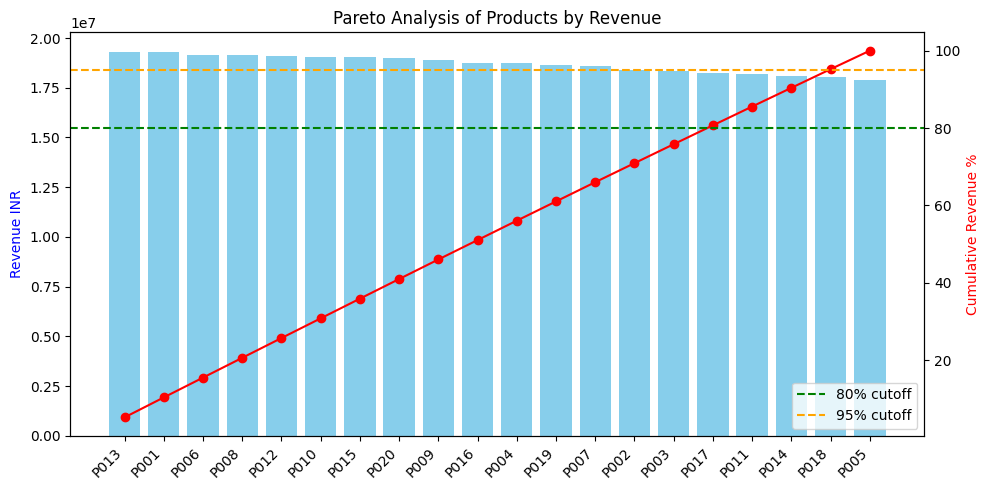

In [112]:
# ============================
# 2.3 Pareto Chart
# ============================
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
ax = plt.gca()

# Bar for revenue
ax.bar(revenue_per_prod["product_id"], revenue_per_prod["revenue_inr"], color="skyblue")
ax.set_ylabel("Revenue INR", color="blue")
ax.set_xticklabels(revenue_per_prod["product_id"], rotation=45, ha="right")

# Line for cumulative share
ax2 = ax.twinx()
ax2.plot(revenue_per_prod["product_id"], revenue_per_prod["cum_share"], color="red", marker="o")
ax2.axhline(80, color="green", linestyle="--", label="80% cutoff")
ax2.axhline(95, color="orange", linestyle="--", label="95% cutoff")
ax2.set_ylabel("Cumulative Revenue %", color="red")
ax2.legend(loc="lower right")

plt.title("Pareto Analysis of Products by Revenue")
plt.tight_layout()
plt.show()

In [113]:
# ============================
# 2.4 A Class SKUs Analysis
# ============================
A_prods = revenue_per_prod[revenue_per_prod["ABC"]=="A"]["product_id"].tolist()
print("A-class products:", A_prods)



A-class products: ['P013', 'P001', 'P006', 'P008', 'P012', 'P010', 'P015', 'P020', 'P009', 'P016', 'P004', 'P019', 'P007', 'P002', 'P003']


# 3. Data Preprocessing

In [114]:
# ============================
# 3.1 Imports
# ============================
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader


In [115]:
# ============================
# 3.2 Pick A Class Product
# ============================
# Pick one product for now
prod_id = "P013"
df_prod = df_weekly[df_weekly["product_id"] == prod_id].copy().reset_index(drop=True)

print("Shape:", df_prod.shape)
display(df_prod.head())


Shape: (80, 12)


,product_id,week_end_date,units_sold,units_returned,revenue_inr,unit_price_inr,promo_flag,discount_rate,avg_temp_c,rainfall_mm,neighborhood_trend_index,is_festival_season
0,P013,2024-01-07,94,11,258824,2653.2,0,0.02,25.04,18.36,97.40,1
1,P013,2024-01-14,79,9,159452,2090.8,0,0.00,26.80,13.08,97.48,1
2,P013,2024-01-21,106,9,271359,2742.0,0,0.00,27.94,13.90,101.08,1
3,P013,2024-01-28,94,11,216133,2250.4,1,0.02,27.86,14.68,103.82,1
4,P013,2024-02-04,100,12,257267,2579.0,1,0.06,27.80,30.86,103.38,0


In [116]:
# ============================
# 3.3. Feature Selection
# ============================
# Target = units_sold
target_col = "units_sold"

# Features: all drivers except product_id/week_end_date
feature_cols = [
    "units_returned", "unit_price_inr", "revenue_inr",
    "promo_flag", "discount_rate", "avg_temp_c", "rainfall_mm",
    "neighborhood_trend_index", "is_festival_season"
]

X = df_prod[feature_cols].values
y = df_prod[target_col].values.reshape(-1,1)

print("X shape:", X.shape, "y shape:", y.shape)


X shape: (80, 9) y shape: (80, 1)


In [117]:
# ============================
# 3.5 Lookback -> Horizon Pairs (fixed target shape)
# ============================
def create_sequences(X, y, lookback=12, horizon=1):
    Xs, ys = [], []
    for i in range(len(X) - lookback - horizon + 1):
        Xs.append(X[i:(i+lookback)])
        # take single step target instead of slice
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)  # y shape (samples,1)


# Split raw arrays first
lookback, horizon = 12, 1
X_seq, y_seq = create_sequences(X, y, lookback, horizon)

n_total = len(X_seq)
n_train = int(n_total * 0.8)
n_val   = int(n_total * 0.10)

X_train_raw, y_train_raw = X_seq[:n_train], y_seq[:n_train]
X_val_raw, y_val_raw     = X_seq[n_train:n_train+n_val], y_seq[n_train:n_train+n_val]
X_test_raw, y_test_raw   = X_seq[n_train+n_val:], y_seq[n_train+n_val:]

# Fit scaler on *flattened* train only
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# reshape for scaler
scaler_X.fit(X_train_raw.reshape(-1, X_train_raw.shape[-1]))
scaler_y.fit(y_train_raw)

# transform
X_train = scaler_X.transform(X_train_raw.reshape(-1, X_train_raw.shape[-1])).reshape(X_train_raw.shape)
X_val   = scaler_X.transform(X_val_raw.reshape(-1, X_val_raw.shape[-1])).reshape(X_val_raw.shape)
X_test  = scaler_X.transform(X_test_raw.reshape(-1, X_test_raw.shape[-1])).reshape(X_test_raw.shape)

y_train = scaler_y.transform(y_train_raw)
y_val   = scaler_y.transform(y_val_raw)
y_test  = scaler_y.transform(y_test_raw)



In [118]:
# ============================
# 3.7 PyTorch Dataset
# ============================
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TimeSeriesDataset(X_train, y_train)
val_ds   = TimeSeriesDataset(X_val, y_val)
test_ds  = TimeSeriesDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=False)
val_dl   = DataLoader(val_ds, batch_size=16, shuffle=False)
test_dl  = DataLoader(test_ds, batch_size=16, shuffle=False)

print("Batches in train_dl:", len(train_dl))

Batches in train_dl: 4


# 4. Models Definition

In [119]:
# ============================
# 4.1 Univariate LSTM
# ============================
import torch.nn as nn

class UniLSTM(nn.Module):
  def __init__(self,hidden_size = 64, num_layers = 1,dropout = 0.0):
    super(UniLSTM,self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    #LSTM Layer
    self.lstm = nn.LSTM(
        input_size = 1, #Only Units sold
        hidden_size = hidden_size,
        num_layers = num_layers,
        batch_first = True,
        dropout = dropout if num_layers>1 else 0.0
    )

    #Output Layer = Regression
    self.fc = nn.Linear(hidden_size,1)
  def forward(self,x):
    #X shape = (batch,lookback,1)
    out, _ = self.lstm(x) #out = (batch,lookback,hidden)
    last = out[:,-1,:] #Last hidden state
    y_pred = self.fc(last) #(batch,1)
    return y_pred

In [120]:
# ============================
# 4.2 Multivariate LSTM
# ============================
class MultiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2, output_size=1):
        super(MultiLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size) #Final Layer alone Linear, try Sigmoid and ReLU (Leaky ReLU), tanh

    def forward(self, x):
        out, _ = self.lstm(x)                 # out: (batch, seq_len, hidden)
        out = out[:, -1, :]                   # take last time step
        out = self.fc(out)                    # (batch, output_size)
        return out


In [121]:
# ============================
# 4.3 Initialize Models
# ============================
model_uni = UniLSTM(hidden_size=64, num_layers=1,dropout=0.0)
print(model_uni)
model_multi = MultiLSTM(input_size=9,hidden_size=64,num_layers=2,dropout=0.2)
print(model_multi)

UniLSTM(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
MultiLSTM(
  (lstm): LSTM(9, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


# 5. Training Loop

In [122]:
# ============================
# 5.1 Loss Function and Optimizer
# ============================
import torch.optim as optim

# Model, loss, optimizer
model = MultiLSTM(input_size=9, hidden_size=32, num_layers=2, dropout=0.1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [123]:
# ============================
# 5.2 Training Function
# ============================
def train_model(model, train_dl, val_dl, criterion, optimizer, epochs=30, patience=5):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        # --- Training ---
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_dl:
            # X_batch already has shape (batch, seq_len, 1)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)  # y_batch already (batch,1)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(X_batch)
        train_loss /= len(train_dl.dataset)

        # --- Validation ---
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_dl:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)  # y_batch already (batch,1)
                val_loss += loss.item() * len(X_batch)
        val_loss /= len(val_dl.dataset)

        # Store losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1:3d}/{epochs} | Train MSE={train_loss:.4f} | Val MSE={val_loss:.4f}")

        # --- Early stopping ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_multilstm.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses


In [124]:
# ============================
# 5.3 Train the model Check Underfitting or Overfitting
# ============================
train_losses, val_losses = train_model(model, train_dl, val_dl, criterion, optimizer, epochs=200, patience=15)

Epoch   1/200 | Train MSE=0.3514 | Val MSE=0.3048
Epoch   2/200 | Train MSE=0.2966 | Val MSE=0.2488
Epoch   3/200 | Train MSE=0.2436 | Val MSE=0.1909
Epoch   4/200 | Train MSE=0.1871 | Val MSE=0.1294
Epoch   5/200 | Train MSE=0.1291 | Val MSE=0.0712
Epoch   6/200 | Train MSE=0.0802 | Val MSE=0.0507
Epoch   7/200 | Train MSE=0.0720 | Val MSE=0.0748
Epoch   8/200 | Train MSE=0.0806 | Val MSE=0.0626
Epoch   9/200 | Train MSE=0.0699 | Val MSE=0.0505
Epoch  10/200 | Train MSE=0.0655 | Val MSE=0.0501
Epoch  11/200 | Train MSE=0.0668 | Val MSE=0.0513
Epoch  12/200 | Train MSE=0.0666 | Val MSE=0.0508
Epoch  13/200 | Train MSE=0.0647 | Val MSE=0.0499
Epoch  14/200 | Train MSE=0.0641 | Val MSE=0.0504
Epoch  15/200 | Train MSE=0.0642 | Val MSE=0.0511
Epoch  16/200 | Train MSE=0.0643 | Val MSE=0.0510
Epoch  17/200 | Train MSE=0.0641 | Val MSE=0.0505
Epoch  18/200 | Train MSE=0.0638 | Val MSE=0.0503
Epoch  19/200 | Train MSE=0.0627 | Val MSE=0.0504
Epoch  20/200 | Train MSE=0.0631 | Val MSE=0.0505


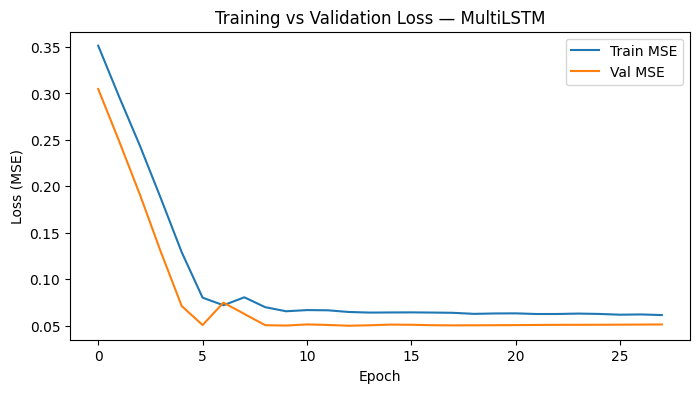

In [125]:
# ============================
# 5.4 Plot Learning Curves
# ============================
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss — MultiLSTM")
plt.legend()
plt.show()


# 6. Model Evaluation

In [126]:
# ============================
# 6.1 Load Best Model
# ============================
best_model = MultiLSTM(input_size=9, hidden_size=32, num_layers=2, dropout=0.1)
best_model.load_state_dict(torch.load("best_multilstm.pt"))
best_model.eval()


MultiLSTM(
  (lstm): LSTM(9, 32, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [127]:
# ============================
# 6.2 Predict Function Check if value tested is SCALED or UNSCALED
# ============================
def predict(model, data_loader, scaler_y):
    preds, trues = [], []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch)
            preds.append(y_pred.numpy())
            trues.append(y_batch.numpy())

    preds = np.concatenate(preds, axis=0)   # (samples, 1)
    trues = np.concatenate(trues, axis=0)   # (samples, 1, 1)

    # Reshape before inverse scaling
    preds = preds.reshape(-1, 1)
    trues = trues.reshape(-1, 1)

    preds = scaler_y.inverse_transform(preds)
    trues = scaler_y.inverse_transform(trues)

    return preds, trues



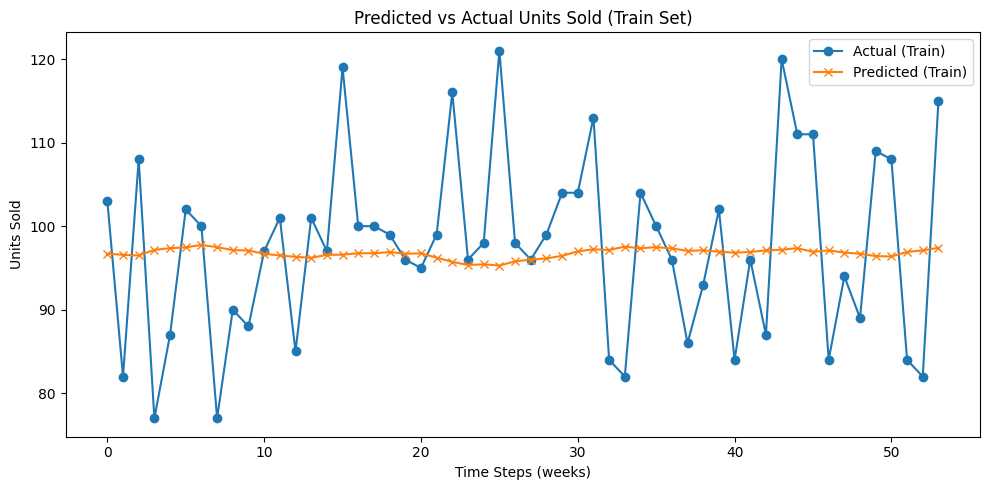

Predictions shape: (8, 1)
True shape: (8, 1)


In [128]:
# ============================
# 6.3 Run on Test
# ============================
y_pred_train, y_true_train = predict(best_model, train_dl, scaler_y)
y_pred, y_true   = predict(best_model, test_dl, scaler_y)

plt.figure(figsize=(10,5))
plt.plot(y_true_train, label="Actual (Train)", marker="o")
plt.plot(y_pred_train, label="Predicted (Train)", marker="x")
plt.title("Predicted vs Actual Units Sold (Train Set)")
plt.xlabel("Time Steps (weeks)")
plt.ylabel("Units Sold")
plt.legend()
plt.tight_layout()
plt.show()
print("Predictions shape:", y_pred.shape)
print("True shape:", y_true.shape)


In [129]:
# ============================
# 6.4. Evaluation Metrics
# ============================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))   # √MSE
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
smape_val = smape(y_true, y_pred)
wape_val  = wape(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

metrics = {
    "MAE": mae,
    "RMSE": rmse,
    "MAPE_%": mape,
    "sMAPE_%": smape_val,
    "WAPE_%": wape_val,
    "R2": r2
}
print("Evaluation Metrics:", metrics)



Evaluation Metrics: {'MAE': 6.412167549133301, 'RMSE': np.float64(8.492901699210991), 'MAPE_%': np.float32(7.033351), 'sMAPE_%': np.float32(6.7998447), 'WAPE_%': np.float32(6.6706553), 'R2': -0.025156497955322266}


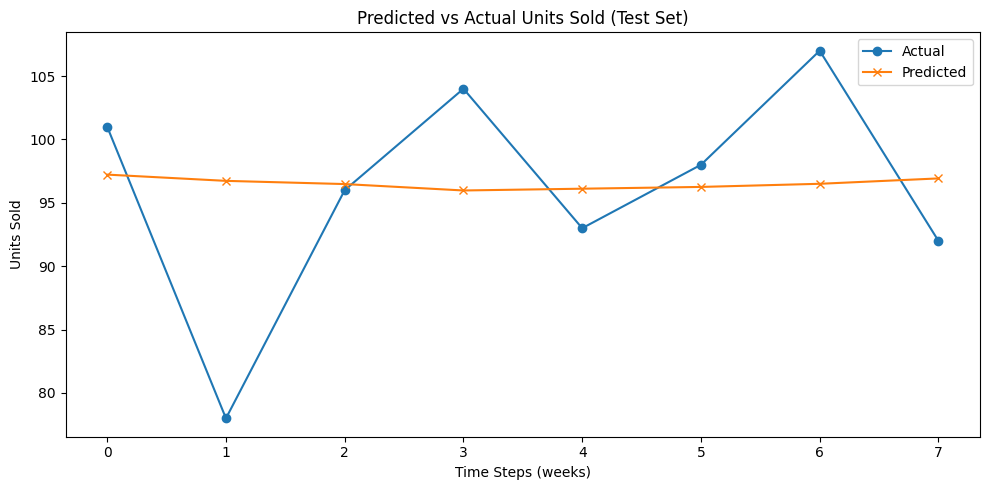

In [130]:
# ============================
# 6.5 Plot Predictions
# ============================
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_true, label="Actual", marker="o")
plt.plot(y_pred, label="Predicted", marker="x")
plt.title("Predicted vs Actual Units Sold (Test Set)")
plt.xlabel("Time Steps (weeks)")
plt.ylabel("Units Sold")
plt.legend()
plt.tight_layout()
plt.show()




# USE TENSORBOARD IF COMPATIBLE WITH PYTORCH